# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import calendar

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cufflinks as cf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import statsmodels.api as sm

In [2]:
# formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [3]:
df = pd.read_csv('./sample.csv', names=['price'])

In [4]:
df.shape

(235, 1)

In [5]:
df.head()

,price
0,0.01
1,0.01
2,0.03
3,0.08
4,0.12


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   235 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


In [7]:
df.describe()

,price
count,235.00
mean,23.42
std,37.97
min,0.00
25%,0.00
50%,0.65
75%,37.03
max,144.39


In [8]:
# add date columns
start_date = pd.to_datetime('2018-01-01')
df['date'] = pd.date_range(start=start_date, periods=len(df), freq='7D')
df['year'] = df.date.dt.year
df['month'] = df['date'].dt.month.apply(lambda x: calendar.month_name[x])

In [9]:
# check new features
df.head()

,price,date,year,month
0,0.01,2018-01-01,2018,January
1,0.01,2018-01-08,2018,January
2,0.03,2018-01-15,2018,January
3,0.08,2018-01-22,2018,January
4,0.12,2018-01-29,2018,January


# Exploratory Data Analysis

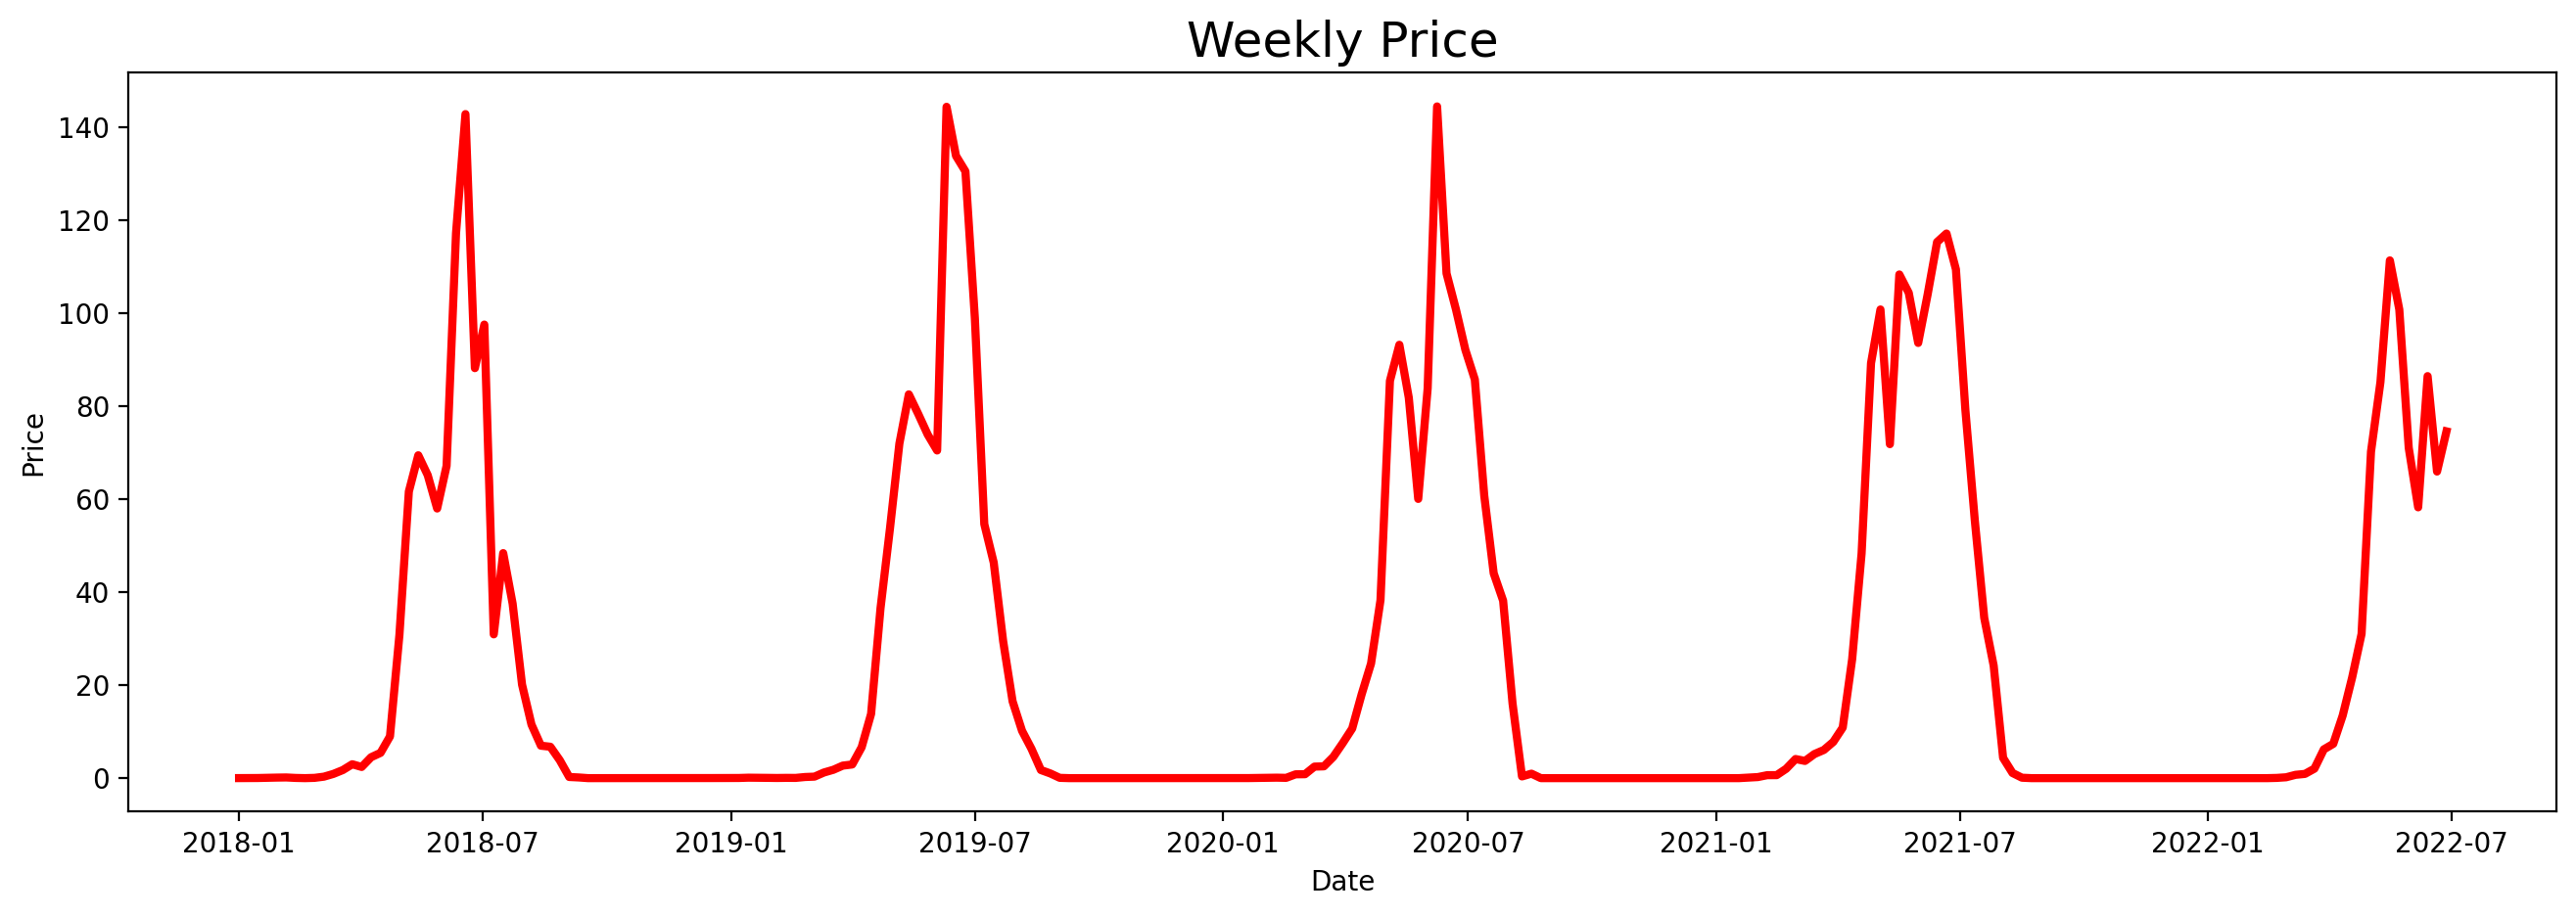

In [10]:
# plot
plt.figure(figsize=(16,5), dpi=200)
plt.title('Weekly Price', fontsize=18)
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df.date, df.price, 
        c='red', 
        linewidth=3,)
plt.show()

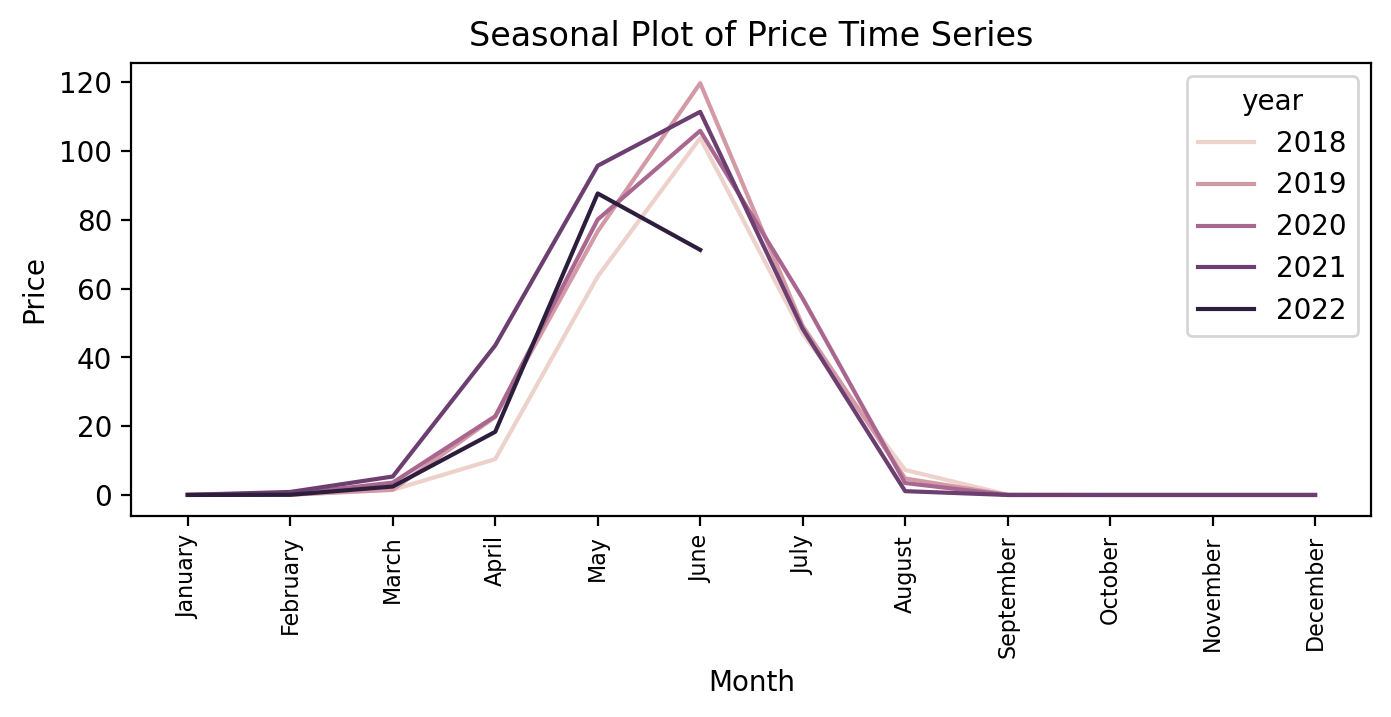

In [11]:
# plot to compare how each year compares against one another
plt.figure(figsize=(8,3), dpi=200)
ax = sns.lineplot(x='month', y='price', hue='year', data=df.reset_index(), ci=None)
ax.set( 
    ylabel = 'Price',
    xlabel = 'Month'
      )
plt.xticks(ticks=np.arange(0, 12, step=1), 
           fontsize=8, 
           rotation=90)

plt.title('Seasonal Plot of Price Time Series')
plt.show()

Seasonal Plot Observations:

1. The year 2022 is a partial year. It is important to be aware of this when analyzing time series data.  Data for year 2022 will be removed as partial year data may adversely impact evaluation of trends in the data.  Later on we'll use 2022 values as test data to see how well our forecast performed
2. The seasonality is consistent each year.  Price increases begin in early spring and decrease in late summer.
3. Prices increases begin in April for year 2021, earlier than other years.  It may be advantageous to investigate the factors contributing to this.

In [12]:
# set up training data
train =  df[df['year'] != 2022]
train.set_index('date', inplace=True)
train.tail()

,price,year,month
date,,,
2021-11-29,0.00,2021,November
2021-12-06,0.00,2021,December
2021-12-13,0.00,2021,December
2021-12-20,0.00,2021,December
2021-12-27,0.00,2021,December


In [13]:
# 2022 data will be saved for testing
test =  df[df['year'] == 2022]
test.set_index('date', inplace=True)
test.head()

,price,year,month
date,,,
2022-01-03,0.00,2022,January
2022-01-10,0.00,2022,January
2022-01-17,0.00,2022,January
2022-01-24,0.00,2022,January
2022-01-31,0.00,2022,January


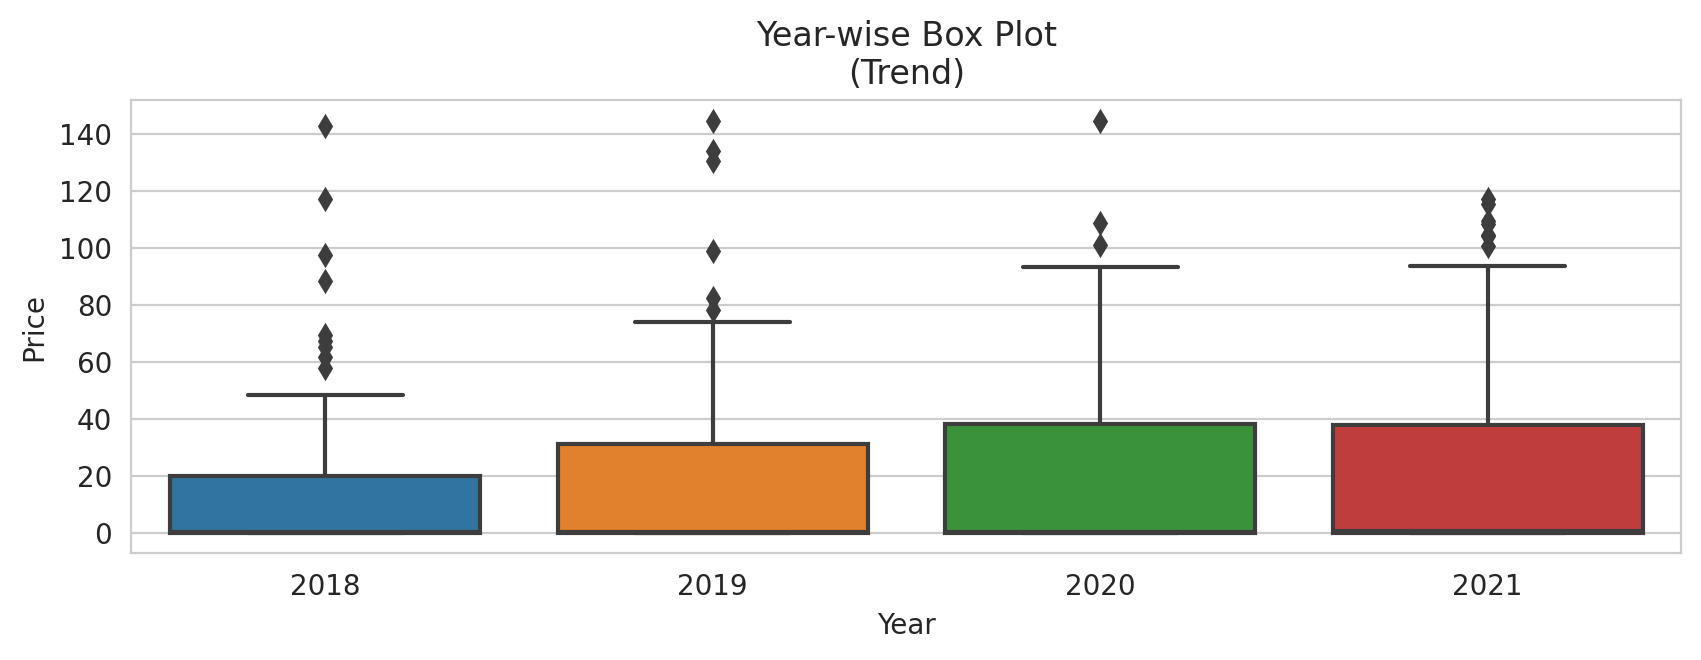

In [14]:
plt.figure(figsize=(10,3), dpi=200)
with sns.axes_style("whitegrid"):
    sns.boxplot(data=train,
                x='year',
                y='price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Year-wise Box Plot\n(Trend)')
plt.show()

Year-wise Box plot observations:
1. The boxplots have fewer outliers for each new year.  This could suggest that prices are becoming less variable or less dispersed over time.
2. When price data is less variable, it becomes easier to forecast future prices and plan accordingly.  This enables more informed decisions to be made about production, inventory, and pricing strategies.

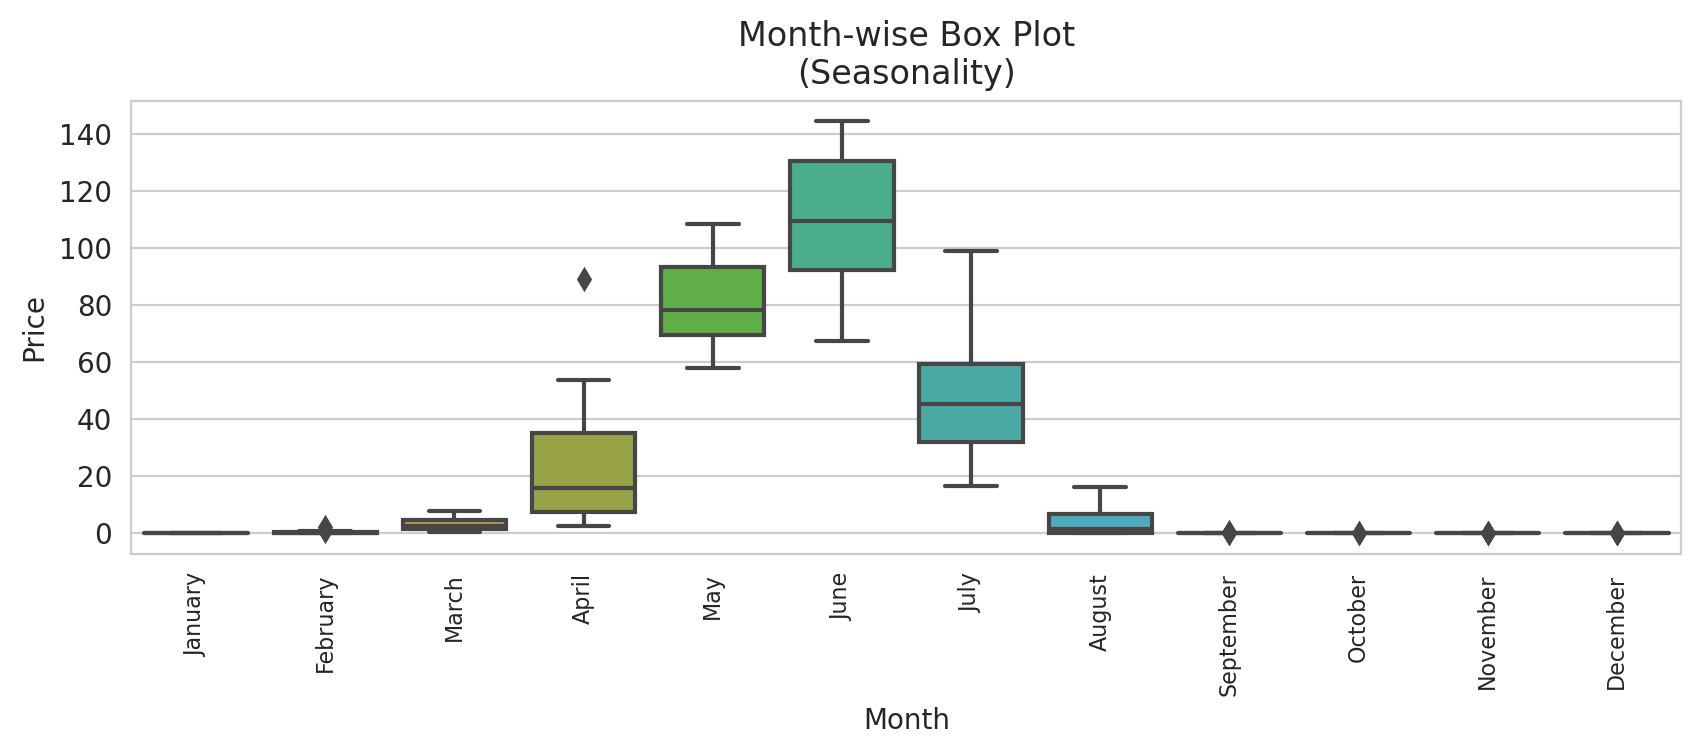

In [15]:
plt.figure(figsize=(10,3), dpi=200)
with sns.axes_style("whitegrid"):
    sns.boxplot(data=train,
                x='month',
                y='price')
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Month-wise Box Plot\n(Seasonality)')
plt.xticks(ticks=np.arange(0, 12, step=1), 
           fontsize=8, 
           rotation=90)
plt.show()

Month-wise Box plot observations:

1. We can clearly see the seasonality present within each year.  Price increases start ramping up in April and winds down in August.
2. Once again, we see the April outlier for the earlier price increase in 2021.  As mentioned previously, this is something we'd want to further investigate.
3. July appears to be the month with the highest variance, followed by June.

In [16]:
# simplify data sets to just date index and price columns
train_final = train.drop(['year','month'], axis=1)
test_final = test.drop(['year','month'], axis=1)
df.set_index('date', inplace=True)
df_final = df.drop(['year','month'], axis=1)

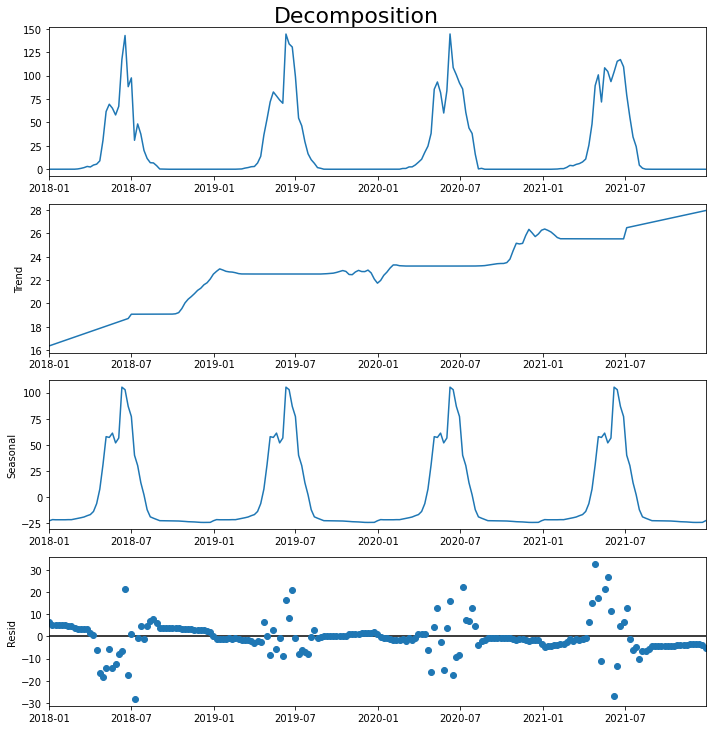

In [17]:
# Decomposition

# Additive Decomposition
result_add = seasonal_decompose(train_final, model='additive', extrapolate_trend='freq')
# setting extrapolate_trend='freq' takes care of any missing values in the trend and residuals at the beginning of the series

# Multiplicative Decomposition
# not applicable because 'price' has zero for some values
# result_mul = seasonal_decompose(df1['price'], model='multiplicative')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Decomposition', fontsize=22, y=1.01)

plt.show()

Decomposition Observations:

1. The trend is increasing each year
2. Seasonality is present, as price increases in early spring and decreases in late summer
3. Residuals appear random for non-zero prices.  This suggests that there is no pattern or structure left in the data that can be explained by the trend or seasonal components and the decomposition has done a good job of explaining the structure in the data (no significant patterns left unexplained).



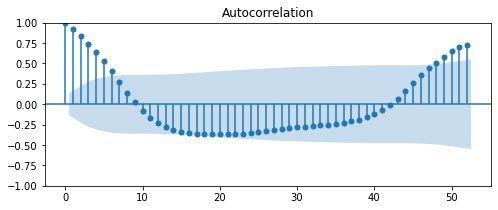

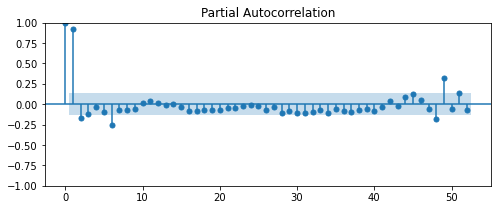

In [18]:
# autocorrelation
fig, ax = plt.subplots(figsize=(8, 3))
fig1, ax1 = plt.subplots(figsize=(8, 3))
acf1 = plot_acf(train_final.price, lags=52, ax=ax)
pacf1 = plot_pacf(train_final.price, lags=52, method='ywmle', ax=ax1)

Autocorrelation Observations:

Autocorrelation is the correlation of a series with its own lags. If a series is significantly autocorrelated, then the previous values of the series (lags) may be helpful in predicting the current value. The PACF lag 1 is highly significant, while ACF lags 1-6 are highly significant. This may be important to know when setting up the ARIMA forecast (p=1, q=6).


In [19]:
# ADF Test
result = adfuller(train_final.price.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.624071905057707
p-value: 0.00011659726665348751
Critial Values:
   1%, -3.462980134086401
Critial Values:
   5%, -2.875885461947131
Critial Values:
   10%, -2.5744164898444515


ADF Test Observations:

The p-value is less than 0.05. The null hypothesis is that the time series is non-stationary. Therefore, we reject the null hypothesis and note that the series is stationary.


In [20]:
# KPSS Test
result = kpss(train_final.price.values, regression='c')

print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.034867
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


KPSS Observations: 

The p-value is greater than 0.05.  The null hypothesis is that the time series is stationary.  Therefore, we accept the null hypothesis and note that the series is stationary.

# Forecast

In [21]:
# ARIMA Model
model = ARIMA(train_final.price, order=(1,0,6)) # order=(p,d,q)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  209
Model:                 ARIMA(1, 0, 6)   Log Likelihood                -837.639
Date:                Fri, 07 Apr 2023   AIC                           1693.278
Time:                        09:22:40   BIC                           1723.359
Sample:                    01-01-2018   HQIC                          1705.440
                         - 12-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.1069     23.369      0.903      0.366     -24.695      66.909
ar.L1          0.8395      0.070     12.037      0.000       0.703       0.976
ma.L1          0.1875      0.081      2.308      0.0

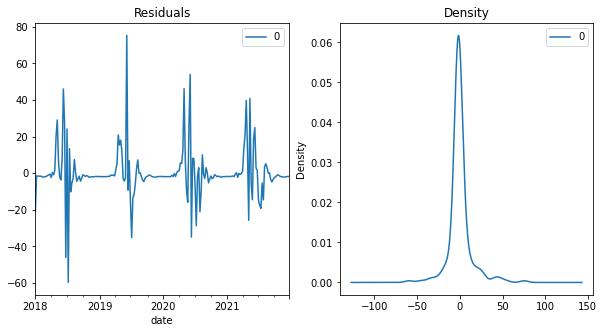

In [22]:
# plot residualts to ensure no patterns are present
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize=(10,5))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

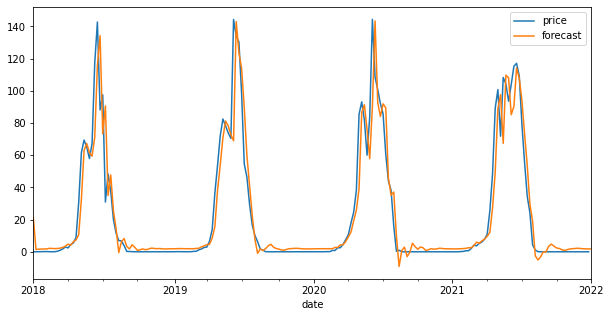

In [23]:
# Actual vs Fitted
fig, ax = plt.subplots()
ax = train_final.plot(ax=ax, figsize=(10,5))
plot_predict(model_fit,alpha=None, start='2018-01-01', end=len(train), ax=ax, dynamic=False)
plt.show()

Prediction Observations: 

These results are promising and certainly pass the eye test, but our first attempt is not necessarily the optimal model.  We can automate the selection of model parameters by using the auto_arima function.  Auto_arima(() uses a stepwise approach to choose the best combination of parameters such as p,d,q.  Additionally, seasonality can be incorporated as well using the P,D,Q parameters.

In [24]:
# Auto SARIMA Model
stepwise_model = auto_arima(train_final, start_p=1, start_q=1,
                           max_p=3, max_q=6, m=52,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=1180.607, Time=4.12 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1199.810, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1178.290, Time=2.58 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1179.230, Time=2.64 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1203.734, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1189.467, Time=0.44 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=1180.253, Time=10.00 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=1180.253, Time=5.45 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=1179.013, Time=3.74 sec
 ARIMA(1,0,0)(2,1,1)[52] intercept   : AIC=1182.254, Time=11.49 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1186.246, Time=2.36 sec
 ARIMA(2,0,0)(1,1,0)[52] intercept   : AIC=1179.936, Time=5.06 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=1180.069, Time=5.29 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=1178.493, Time=3.52 sec
 ARIMA(2,0,1)(1,1

Updated Forecast Observations:

1. The best model was chosen to achieve the lowest AIC
2. Seasonality has been incorporated into the new model
3. Let's visualize the results below by comparing the forecast to the actual data in 2022.


In [25]:
stepwise_model.fit(train_final)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 1, 0, 52),
      suppress_warnings=True)

In [26]:
future_forecast = stepwise_model.predict(n_periods=26)
future_forecast

2022-01-03     2.03
2022-01-10     2.53
2022-01-17     2.66
2022-01-24     2.78
2022-01-31     2.85
2022-02-07     3.13
2022-02-14     3.13
2022-02-21     4.26
2022-02-28     5.59
2022-03-07     5.94
2022-03-14     6.89
2022-03-21     8.20
2022-03-28    10.39
2022-04-04    13.49
2022-04-11    25.46
2022-04-18    42.21
2022-04-25    72.97
2022-05-02    97.74
2022-05-09    82.43
2022-05-16   101.11
2022-05-23    90.54
2022-05-30    92.62
2022-06-06   121.69
2022-06-13   115.43
2022-06-20   113.70
2022-06-27   105.62
Freq: W-MON, dtype: float64

In [27]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['prediction'])

In [28]:
cf.go_offline()
pd.concat([future_forecast, test_final],axis=1).iplot()

In [29]:
#compare to the entire data set
pd.concat([future_forecast, df_final],axis=1).iplot()

Conclusions:

This is a good starting point for building a forecasting model to predict price for future years.  We can see that the model is picking up on the seasonality that occurs from early spring to late summer.  We could extend the model into future years to help make more informed decisions about production, inventory, and pricing strategies.